In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import random_split
import os
import tarfile
import random
import time
import datetime
from torchvision.datasets.utils import download_url
%matplotlib inline

In [2]:
#torch.manual_seed(0)   #You can use torch.manual_seed() to seed the RNG for all devices (both CPU and CUDA)
#random.seed(0)         #For custom operators, you might need to set python seed
#np.random.seed(0)      #If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG

# Download dataset from a specific URL 

In [8]:
# Dowload the dataset Option-I
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, './cifer10_data')

100.0%

In [3]:
# Extract from archive
with tarfile.open('./cifer10_data/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./cifer10_data/data')

In [2]:
data_dir = './cifer10_data/data/cifar10'

img_files = os.listdir(data_dir + "/train/truck")
print('No. of training examples for Trucks:', len(img_files))
print(img_files[:5])

No. of training examples for Trucks: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [3]:
#AUGMENTATIONS
transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  #torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.5, hue=0.1),
  transforms.RandomHorizontalFlip(),
  torchvision.transforms.RandomVerticalFlip(),
  #torchvision.transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=None,shear=50, resample=False, fillcolor=0),
  torchvision.transforms.RandomRotation((20), resample=False,expand=False, center=None),
  transforms.ToTensor(),
  transforms.Normalize([0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628])
])

dataset = ImageFolder(data_dir+'/train', transform=transform)
viewdataset = ImageFolder(data_dir+'/train', transform=ToTensor())
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [5]:
batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
view_dl = DataLoader(viewdataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([32, 3, 32, 32])


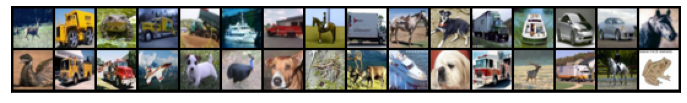

In [6]:
def show_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
show_batch(view_dl)

In [7]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        current_time = datetime.datetime.now()
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, cur_time: {}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'], current_time))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class RACifer10Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), #applying batch norm
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), #applying batch norm
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), #applying batch norm
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), #applying batch norm
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), #applying batch norm
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.AvgPool2d(kernel_size=4)
        )
        
        self.network2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), #applying batch norm
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), #applying batch norm
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), #applying batch norm
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), #applying batch norm
            nn.ReLU(),
            
            #nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            nn.AvgPool2d(kernel_size=4)
        )
        
        self.fc1 = nn.Linear(in_features=256*2*2,out_features=1024)
        self.fc2 = nn.Linear(in_features=1024,out_features=512)
        self.fc3 = nn.Linear(in_features=512,out_features=10)
        
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)
    
    #@torch.jit.script_method
    def forward(self, xb):
        out1 = self.network1(xb)
        out2 = self.network2(xb)
               
        out1 = out1.view(-1,256*2*2)
        out1 = self.fc1(out1)
        out1 = self.dropout(out1)
        out1 = F.relu(out1)
        out2 = out2.view(-1,256*2*2)
        out2 = self.fc1(out2)
        out2 = self.dropout(out2)
        out2 = F.relu(out2)
        
        out1 = self.fc2(out1)
        out1 = self.dropout(out1)
        out1 = F.relu(out1)
        out2 = self.fc2(out2)
        out2 = self.dropout(out2)
        out2 = F.relu(out2)
        
        output =  torch.cat([out1, out2], dim=1)
        output = self.fc2(output)
        output = self.dropout(output)
        output = F.relu(output)
        
        output = self.fc3(output)
        
        return output
    

model = RACifer10Net()
model

RACifer10Net(
  (network1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [10]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, model_no, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    best_loss = np.Inf
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            if loss < best_loss:
                best_loss = loss
                # define and save filename for this ensemble
                filename = 'models/model_' + str(model_no) + '.pth'
                torch.save(model.state_dict(), filename)
                                
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
model = to_device(RACifer10Net(), device)
evaluate(model, val_dl)

{'val_loss': 2.302380323410034, 'val_acc': 0.09968354552984238}

In [12]:
# Run models from file
def run_all_models(n_models, model):
    all_models = list()
    tt =0
    for i in range(n_models):
        model_no = i+1
        print('For Model-' + str(model_no))
        # fit model
        st = time.time()
        history = fit(num_epochs, lr, model, train_dl, val_dl, model_no, opt_func)
        tt += time.time() - st
        # add to list of members
        all_models.append(model)
        model = to_device(RACifer10Net(), device)
        
    print('Total Training Time {:.4f}'.format(tt))
    return all_models, history

In [13]:
# load all models
num_epochs = 100
opt_func = torch.optim.Adam   #torch.optim.SGD 
lr = 0.001
n_members = 1
members, history = run_all_models(n_members, model)
print('Loaded {} models'.format(len(members)))

For Model-1
Epoch [0], train_loss: 1.7385, val_loss: 1.5748, val_acc: 0.4159, cur_time: 2021-05-05 15:02:17.225008
Epoch [1], train_loss: 1.4902, val_loss: 1.3537, val_acc: 0.5014, cur_time: 2021-05-05 15:03:06.740689
Epoch [2], train_loss: 1.3818, val_loss: 1.2343, val_acc: 0.5378, cur_time: 2021-05-05 15:03:58.590554
Epoch [3], train_loss: 1.2958, val_loss: 1.2166, val_acc: 0.5613, cur_time: 2021-05-05 15:04:55.605375
Epoch [4], train_loss: 1.2211, val_loss: 1.1127, val_acc: 0.5949, cur_time: 2021-05-05 15:05:53.938777
Epoch [5], train_loss: 1.1618, val_loss: 1.1079, val_acc: 0.6098, cur_time: 2021-05-05 15:06:56.782972
Epoch [6], train_loss: 1.1061, val_loss: 1.0267, val_acc: 0.6371, cur_time: 2021-05-05 15:07:57.892495
Epoch [7], train_loss: 1.0730, val_loss: 0.9568, val_acc: 0.6568, cur_time: 2021-05-05 15:08:59.000259
Epoch [8], train_loss: 1.0226, val_loss: 0.9262, val_acc: 0.6628, cur_time: 2021-05-05 15:10:00.035398
Epoch [9], train_loss: 0.9872, val_loss: 0.9109, val_acc: 0.6

Epoch [79], train_loss: 0.3859, val_loss: 0.4671, val_acc: 0.8497, cur_time: 2021-05-05 16:24:02.996855
Epoch [80], train_loss: 0.3851, val_loss: 0.4826, val_acc: 0.8438, cur_time: 2021-05-05 16:25:04.998846
Epoch [81], train_loss: 0.3786, val_loss: 0.4651, val_acc: 0.8566, cur_time: 2021-05-05 16:26:07.098676
Epoch [82], train_loss: 0.3816, val_loss: 0.4478, val_acc: 0.8534, cur_time: 2021-05-05 16:27:09.340507
Epoch [83], train_loss: 0.3878, val_loss: 0.4705, val_acc: 0.8463, cur_time: 2021-05-05 16:28:12.040801
Epoch [84], train_loss: 0.3893, val_loss: 0.4503, val_acc: 0.8534, cur_time: 2021-05-05 16:29:14.325818
Epoch [85], train_loss: 0.3680, val_loss: 0.4386, val_acc: 0.8525, cur_time: 2021-05-05 16:30:16.579589
Epoch [86], train_loss: 0.3716, val_loss: 0.4450, val_acc: 0.8473, cur_time: 2021-05-05 16:31:18.830413
Epoch [87], train_loss: 0.3808, val_loss: 0.4432, val_acc: 0.8536, cur_time: 2021-05-05 16:32:21.705599
Epoch [88], train_loss: 0.3635, val_loss: 0.4554, val_acc: 0.854

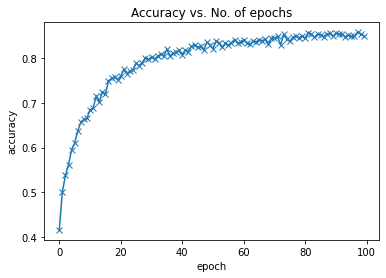

In [14]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

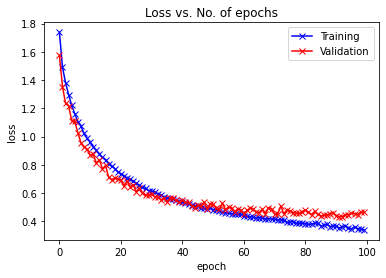

In [15]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
For Model-1
>loaded models/model_1.pth
Model- 1 Label: automobile , Predicted: automobile

Predicted class indices: [1]

Finally, Label: automobile , Predicted: automobile


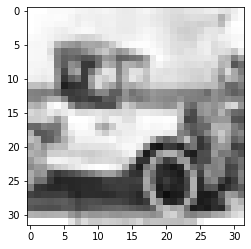

In [19]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628])
])

test_dataset = ImageFolder(data_dir+'/test', transform=transform)
test_view = ImageFolder(data_dir+'/test', transform=ToTensor())
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)

# evaluate standalone models on test dataset
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

# Load models from file
def load_all_models(n_models, img):
    yhat = list()
    for i in range(n_models):
        print('For Model-' + str(i + 1))
        # define and load filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.pth'
        device = torch.device("cuda")
        model = RACifer10Net()
        model.load_state_dict(torch.load(filename, map_location=device))
        print('>loaded %s' % filename)
        model.to(device)
        model.eval()
        yhat.append(dataset.classes.index(predict_image(img, model)))
        print('Model-', str(i+1), 'Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
        
    return yhat

img, label = test_view[1002]
plt.imshow(img.permute(1, 2, 0))
img, label = test_dataset[1002]
n_members = 1
yhat = load_all_models(n_members, img)
print('\nPredicted class indices:',yhat)

yhat = max(set(yhat), key = yhat.count)    
print('\nFinally, Label:', dataset.classes[label], ', Predicted:', classes[yhat])

In [20]:
from statistics import mean

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628])
])

test_dataset = ImageFolder(data_dir+'/test', transform=transform)

# Load models from file
def evaluate_test_models(n_models, test_dl):
    results = list()
    for i in range(n_models):
        print('For Model-' + str(i + 1))
        # define and load filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.pth'
        device = torch.device("cuda")
        model = RACifer10Net()
        model.load_state_dict(torch.load(filename, map_location=device))
        print('>loaded %s' % filename)
        model.to(device)
        model.eval()
        result = evaluate(model, test_dl)
        results.append(result)
        print(result)
        
    return results

def mean_from_dict(res):
    # loop to sum all values 
    v = 0
    for i in range(len(res)):
        val = res[i].get('val_acc')
        v += val
  
    # using len() to get total keys for mean computation
    v = v / len(res)
    
    return v


test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
n_members = 1
res = evaluate_test_models(n_members, test_loader)
mean_val_acc=mean_from_dict(res)
print('\nMean Validation Accuracy: ', mean_val_acc)

For Model-1
>loaded models/model_1.pth
{'val_loss': 0.39667171239852905, 'val_acc': 0.8725119233131409}

Mean Validation Accuracy:  0.8725119233131409
